In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Infosys-springboard-internship/content/Processed

label_map.json	X.npy  y.npy


In [3]:
import numpy as np

In [4]:
X = np.load('/content/drive/MyDrive/Infosys-springboard-internship/content/Processed/X.npy')
y = np.load('/content/drive/MyDrive/Infosys-springboard-internship/content/Processed/y.npy')
print(X.shape)
print(y.shape)

(5600, 128, 128)
(5600,)


In [5]:
# Right now, X looks like this:
# (number_of_samples, height, width)
# Example: (5600, 128, 128)

# CNNs don't like "flat images".
# They expect a channel dimension, just like:
# - RGB images → 3 channels
# - Grayscale images → 1 channel

# Our spectrograms are grayscale,
# so we manually add a "1" channel at the end.

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Always print shape after reshaping.
# This is a sanity check to make sure nothing broke.
print("New X shape:", X.shape)


New X shape: (5600, 128, 128, 1)


In [6]:

# Right now, y contains labels like:
# "Guitar", "Flute", "Bass", etc.

# Neural networks DO NOT understand text.
# They only understand numbers.

# LabelEncoder converts each instrument name
# into a unique integer.
# Example:
# Guitar → 3
# Flute  → 1
# Bass   → 0

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit = learn all unique labels
# Transform = convert labels to numbers
y_encoded = encoder.fit_transform(y)

# Print the mapping so we KNOW what number means what
print("Instrument classes (label order):")
print(encoder.classes_)
print("Encoded labels shape:", y_encoded.shape)

Instrument classes (label order):
[0 1 2 3 4 5 6 7]
Encoded labels shape: (5600,)


In [7]:
# If we train and test on the same data,
# the model might just MEMORIZE instead of LEARN.

# So we hide 20% of the data from the model.
# This hidden data is called the validation set.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,      # 20% for validation
    random_state=42,    # makes results reproducible
    stratify=y_encoded  # keeps class balance intact
)

# Print shapes to verify split worked correctly
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

Training data shape: (4480, 128, 128, 1) (4480,)
Validation data shape: (1120, 128, 128, 1) (1120,)


In [8]:
# TensorFlow is our deep learning engine
# Keras is the high-level API we use to build the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
# Sequential model = straight pipeline (perfect for baseline CNN)
model = Sequential()

# ---- Explicit Input Layer ----
# This tells the model exactly what ONE input looks like.
# Shape = (height, width, channels)
# Using Input() avoids Keras warnings and is best practice.

model.add(Input(shape=(128, 128, 1)))

# ---- Convolution Block 1 ----
# Learns simple visual patterns in spectrograms
# like edges, frequency bands, and short transients

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Convolution Block 2 ----
# Learns more complex combinations of patterns

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Flatten ----
# Converts 2D feature maps into a 1D vector
# so Dense layers can work with it

model.add(Flatten())

# ---- Dense Layer ----
# This is the "thinking" part of the network

model.add(Dense(128, activation='relu'))

# Dropout = randomly turn off neurons during training
# Helps prevent overfitting (memorization)

model.add(Dropout(0.5))

# ---- Output Layer ----
# One neuron per instrument class
# Softmax turns outputs into probabilities

model.add(Dense(len(set(y_encoded)), activation='softmax'))


In [10]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,776 (28.20 MB)

 Trainable params: 7,392,776 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

# Task
Train the defined CNN model with `X_train`, `y_train`, `X_val`, and `y_val`, specifying an appropriate number of epochs.

## Train the CNN Model

### Subtask:
Train the defined CNN model using the training data (X_train, y_train) and validate its performance on the validation data (X_val, y_val). This step will involve calling `model.fit()` with appropriate epochs and validation data.


**Reasoning**:
Train the compiled CNN model using the training data and validate its performance using the validation data, storing the training history.



In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.2398 - loss: 1.9892 - val_accuracy: 0.3321 - val_loss: 1.7469
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 127s 903ms/step - accuracy: 0.3504 - loss: 1.6981 - val_accuracy: 0.4161 - val_loss: 1.5187
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 131s 933ms/step - accuracy: 0.4106 - loss: 1.5664 - val_accuracy: 0.4795 - val_loss: 1.3762
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 137s 898ms/step - accuracy: 0.4656 - loss: 1.4105 - val_accuracy: 0.4955 - val_loss: 1.4248
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 154s 988ms/step - accuracy: 0.4884 - loss: 1.3320 - val_accuracy: 0.5330 - val_loss: 1.2639
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 132s 944ms/step - accuracy: 0.5131 - loss: 1.2716 - val_accuracy: 0.5420 - val_loss: 1.2205
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 141s 934ms/step - accuracy: 0.5445 - loss: 1.2288 - val_accuracy: 0.5625 - val_loss: 1.1562
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 124s 884ms/step - accuracy: 0.5329 - lo

# Task
Plot the training and validation accuracy and loss over epochs using the `history` object, generate a confusion matrix using the validation data and `encoder.classes_`, and save the trained model as 'instrunet_model_v1.h5'. Afterwards, summarize the model's performance, insights from the plots and confusion matrix, and confirm the model saving.

## Plot Learning Curves

### Subtask:
Generate plots for the training and validation accuracy, as well as training and validation loss, over the epochs. This visual representation will help assess if the model is learning effectively or overfitting. Ensure the plots include proper labels and a legend.


**Reasoning**:
To visualize the model's performance over epochs, I will generate plots for training/validation accuracy and training/validation loss using `matplotlib.pyplot`.



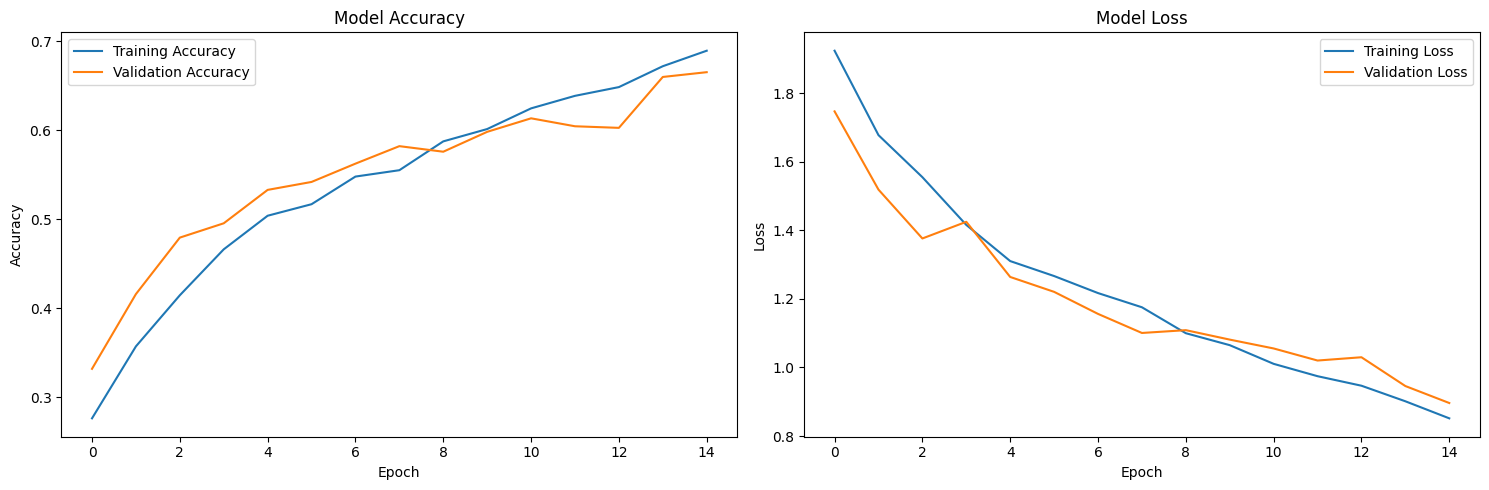

In [13]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

## Generate Confusion Matrix

### Subtask:
Generate a confusion matrix to visualize the performance of the trained CNN model on the validation data (`X_val`, `y_val`). The confusion matrix will show how well the model classified each instrument and highlight any misclassifications. Use `encoder.classes_` for meaningful labels.

#### Instructions
1. Predict the classes for the validation data `X_val` using `model.predict()`.
2. Convert the predicted probabilities into class labels using `np.argmax()`.
3. Create the confusion matrix using `sklearn.metrics.confusion_matrix` with `y_val` and the predicted labels.
4. Plot the confusion matrix using `seaborn.heatmap`. Make sure to label the axes with `encoder.classes_` for clarity.
5. Add a title to the plot, for example, 'Confusion Matrix'.

**Reasoning**:
The previous step outlined the subtask of generating a confusion matrix. Now, I will provide the Python code to implement this, including predicting validation data, converting predictions to labels, computing the confusion matrix, and plotting it using seaborn.



35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step


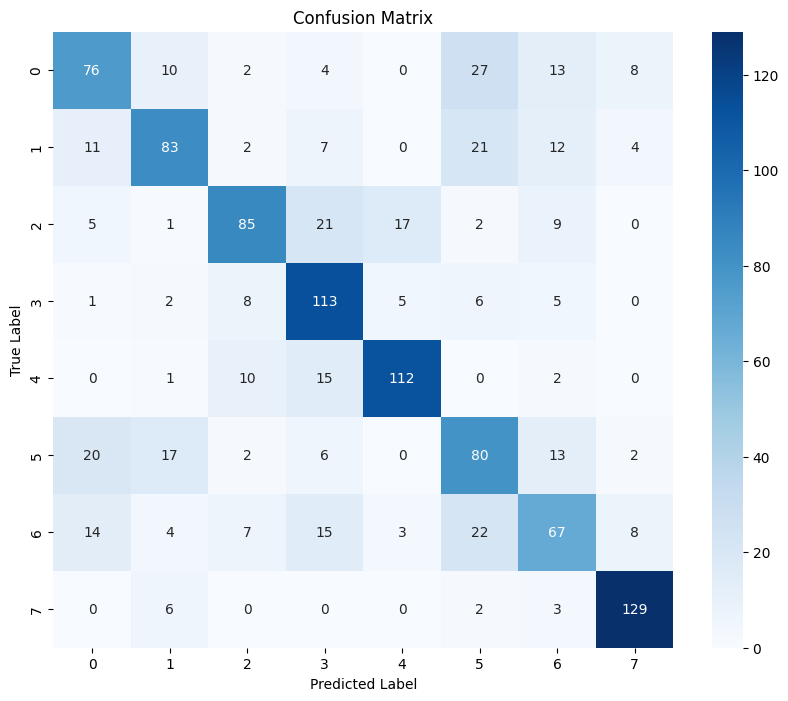

In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Predict the classes for the validation data X_val
y_pred_prob = model.predict(X_val)

# 2. Convert the predicted probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# 3. Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# 4. Plot the confusion matrix using seaborn.heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# 5. Add a title to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Save the Trained Model

### Subtask:
Save the trained CNN model to a file. This allows for future use of the model without needing to retrain it, making it easy to deploy or evaluate further.

#### Instructions
1. Save the model in the Keras H5 format using `model.save()`. Choose a descriptive filename, for example, `'instrunet_model_v1.h5'`.

**Reasoning**:
The subtask is to save the trained CNN model. I will use the `model.save()` function to save the model in the H5 format as specified.



In [15]:
model.save('instrunet_model_v1.h5')
print("Model saved successfully as 'instrunet_model_v1.h5'")

Model saved successfully as 'instrunet_model_v1.h5'
